In [1]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import punkt
from nltk.corpus.reader import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
path_svm =  'Models/best_lrc.pickle'
with open(path_svm, 'rb') as data:
    svc_model = pickle.load(data)
    

path_tfidf = "Pickles/tfidf.pickle"
with open(path_tfidf, 'rb') as data:
    tfidf = pickle.load(data)

path_df = "compilation_clean.pkl"
with open(path_df, 'rb') as data:
    df = pickle.load(data)
    
path_df = "Pickles/DFNONE.pickle"
with open(path_df, 'rb') as data:
    dfToTag = pickle.load(data)
    
path_category_names = "Pickles/category_names.pickle"
with open(path_category_names, 'rb') as data:
    category_names = pickle.load(data)
    
path_category_codes = "Pickles/category_codes.pickle"
with open(path_category_codes, 'rb') as data:
    category_codes = pickle.load(data)

In [3]:
punctuation_signs = list("?:!.,;")
stop_words = list(stopwords.words('english'))

def create_features_from_text(text):
    
    # Dataframe creation
    lemmatized_text_list = []
    df = pd.DataFrame(columns=['Content'])
    df.loc[0] = text
    df['Content_Clean'] = df['Content'].str.replace("\r", " ")
    df['Content_Clean'] = df['Content_Clean'].str.replace("\n", " ")
    df['Content_Clean'] = df['Content_Clean'].str.replace("    ", " ")
    df['Content_Clean'] = df['Content_Clean'].str.replace('"', '')
    df['Content_Clean'] = df['Content_Clean'].str.lower()
    df['Content_Clean'] = df['Content_Clean']
    for punct_sign in punctuation_signs:
        df['Content_Clean'] = df['Content_Clean'].str.replace(punct_sign, '')
    df['Content_Clean'] = df['Content_Clean'].str.replace("'s", "")
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_list = []
    text = df.loc[0]['Content_Clean']
    text_words = text.split(" ")
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    lemmatized_text = " ".join(lemmatized_list)    
    lemmatized_text_list.append(lemmatized_text)
    df['Content_Clean'] = lemmatized_text_list
    df['Content_Clean'] = df['Content_Clean']
    for stop_word in stop_words:
        regex_stopword = r"\b" + stop_word + r"\b"
        df['Content_Clean'] = df['Content_Clean'].str.replace(regex_stopword, '')
    df = df['Content_Clean']
    #df = df.rename(columns={'Content_Parsed_6': 'Content_Parsed'})
    #df = df.rename(columns={"A": "a", "B": "c"})
    # TF-IDF
    features = tfidf.transform(df).toarray()
    
    return features

In [4]:
def get_category_name(category_id):
    for category, id_ in category_codes.items():    
        if id_ == category_id:
            return category

In [5]:
def predict_from_text(text,debug):
    
    # Predict using the input model
    prediction_svc = svc_model.predict(create_features_from_text(text))[0]
    prediction_svc_proba = svc_model.predict_proba(create_features_from_text(text))[0]
    
    # Return result
    category_svc = get_category_name(prediction_svc)
    scoring = prediction_svc_proba.max()*100
    if debug:
        print("The predicted category using the model is %s." %(category_svc) )
        print("The conditional probability is: %a" %(scoring))
    
    return prediction_svc,scoring,category_svc

In [6]:
predict_from_text("  ndt gauge ",True)

The predicted category using the model is PiezosNDT.
The conditional probability is: 73.7147722868734


(3, 73.7147722868734, 'PiezosNDT')

In [7]:
TODO = dfToTag
#TODO = df
TODO["Hypothese"] = TODO["Title"].apply(lambda x: predict_from_text(str(x),False))
TODO[['new_group','confidence','new_category']] = pd.DataFrame(TODO.Hypothese.values.tolist(), index= TODO.index)
TODO[["ItemID","ViewItemURLForNaturalSearch","Title","group",'confidence',"new_category"]].to_excel("verification.xlsx")
TODO

,ItemID,value,_currencyID,ViewItemURLForNaturalSearch,Title,PrimaryCategoryID,Country,Description,group,Hypothese,new_group,confidence,new_category
0,293595138284,1020.0,USD,https://www.ebay.com/itm/Edan-L741-Ultrasound-...,Edan L741 Ultrasound Transducer New Compatible,184515,RU,This is a Premium compatible / generic probe f...,None,"(0, 60.69282194080118, Array)",0,60.692822,Array
1,293595156659,1860.0,USD,https://www.ebay.com/itm/Esaote-LA522E-Ultraso...,Esaote LA522E Ultrasound Transducer New Compat...,184515,RU,This is a Premium compatible / generic probe f...,None,"(0, 60.69282194080118, Array)",0,60.692822,Array
2,293595191213,1860.0,USD,https://www.ebay.com/itm/Ge-3C-RS-Ultrasound-T...,Ge 3C-RS Ultrasound Transducer New Compatible,184515,RU,This is a Premium compatible / generic probe f...,None,"(0, 84.85713716372564, Array)",0,84.857137,Array
3,293595143491,1020.0,USD,https://www.ebay.com/itm/Edan-E611-1-Ultrasoun...,Edan E611-1 Ultrasound Transducer New Compatible,184515,RU,This is a Premium compatible / generic probe f...,None,"(0, 60.69282194080118, Array)",0,60.692822,Array
4,293595166924,960.0,USD,https://www.ebay.com/itm/Fukuda-FUT-CS602-5AJ-...,Fukuda FUT-CS602-5AJ Ultrasound Transducer New...,184515,RU,This is a Premium compatible / generic probe f...,None,"(0, 60.69282194080118, Array)",0,60.692822,Array
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3674,293502381198,8.04,USD,https://www.ebay.com/itm/2pcs-TMP8085AP-2-UPC-...,[2pcs] TMP8085AP-2 UPC 8-Bit 3MHz NMOS DIP40 T...,159680,PL,.belka_amber {background: #006699;filter: prog...,None,"(1, 75.49987061569473, NotUS)",1,75.499871,NotUS
3675,333568410927,41.7,USD,https://www.ebay.com/itm/Pregnant-Ultrasonic-F...,Pregnant Ultrasonic Fetal Doppler 2.5MHz Probe...,117028,US,\t\t\tDescription \...,None,"(5, 90.68004325937761, Fetal)",5,90.680043,Fetal
3676,202865770570,5.29,USD,https://www.ebay.com/itm/1SS315-Toshiba-Schott...,"1SS315 - Toshiba Schotty Barriera Diodo - 5V,3...",11704,GB,"1SS315 (TPH3, F) - Diodo barriera Toshiba Scho...",None,"(1, 87.26790270163005, NotUS)",1,87.267903,NotUS
3677,274375932779,30.31,USD,https://www.ebay.com/itm/6g9q9e882ca-luftventi...,6g9q9e882ca luftventil ford galaxy (ca1) ghia ...,33548,ES,"Desguaces Motocoche - Ebay @charset ""utf-8...",None,"(1, 98.55207867924268, NotUS)",1,98.552079,NotUS


# Review of the model

In [8]:
new = pd.read_excel("verification.xlsx")
print(new.columns.tolist())
new.head()

['Unnamed: 0', 'ItemID', 'ViewItemURLForNaturalSearch', 'Title', 'group', 'confidence', 'new_category', 'reviewed']


,Unnamed: 0,ItemID,ViewItemURLForNaturalSearch,Title,group,confidence,new_category,reviewed
0,338,392835108835,https://www.ebay.com/itm/World-Wide-TransPorta...,(World Wide-TransPortable)(01)MEDISON HC3-6 Co...,None,87.892150,Array,Array
1,806,373081352874,https://www.ebay.com/itm/World-Wide-Transporta...,(World Wide-Transportable)ALOKA UST 944B 3.5 M...,None,93.872486,Array,Array
2,170,373083973782,https://www.ebay.com/itm/World-Wide-Transporta...,(World Wide-Transportable)GE Ultrasound C364 C...,None,94.791821,Array,Array
3,355,373083974413,https://www.ebay.com/itm/World-Wide-Transporta...,(World Wide-Transportable)SIEMENS Transvaginal...,None,69.950549,Array,Array
4,2924,293502380734,https://www.ebay.com/itm/2pcs-BF180-NPN-20V-20...,[2pcs] BF180 NPN 20V 20mA 650MHz TO18-4 SIEMENS,None,98.159140,NotUS,NotUS


In [9]:
import os
pathimg = "/home/kelu/ultrasound/ebaystrove/images/"
if "reviewed" in new.columns.tolist():
    print("OK")
    for row in range(len(new)):
        if new.iloc[row]["group"] == "None":
            pathfrom = pathimg + str(new.iloc[row]["ItemID"])
        else:
            pathfrom = pathimg + new.iloc[row]["group"] + "/" + str(new.iloc[row]["ItemID"])
        pathto = pathimg + new.iloc[row]["reviewed"] + "/"
        print(pathto)

        try:
            os.rename(pathfrom + ".jpg", pathto+str(new.iloc[row]["ItemID"])+".jpg")
        except:
            print ("pathfrom",pathfrom+".jpg","\n","Path to",pathto+str(new.iloc[row]["ItemID"])+".jpg","error")

OK
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293502380734.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/293502380734.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/392717129054.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/392717129054.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293502382074.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/293502382074.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293502382080.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/293502382080.jpg error
/home/kelu/ultrasound/ebaystrove/images/N

/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/FullMachine/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/111898578176.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/111898578176.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/274016944639.jpg 
 Path to /home/kelu/ultrasound

pathfrom /home/kelu/ultrasound/ebaystrove/images/402197448691.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/402197448691.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/373007325630.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/373007325630.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/373007350726.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/373007350726.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/373007353289.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/373007353289.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/373007351809.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/373007351809.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrov

/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/Wireless/
pathfrom /home/kelu/ultrasound/ebaystrove/images/114104681821.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Wireless/114104681821.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/ho

pathfrom /home/kelu/ultrasound/ebaystrove/images/293612831693.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293612831693.jpg error
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293612795556.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293612795556.jpg error
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293612832318.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293612832318.jpg error
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293612792505.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293612792505.jpg error
/home/kelu/ultrasound/ebaystrove/images/Arra

/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/264383075338.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/264383075338.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/303165315889.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/303165315889.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/362669738250.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/362669738250.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/264383072197.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/264383072197.jpg err

/home/kelu/ultrasound/ebaystrove/images/PiezosNDT/
pathfrom /home/kelu/ultrasound/ebaystrove/images/362669737977.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/PiezosNDT/362669737977.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/223488083431.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/223488083431.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/264289775660.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/264289775660.jpg error
/home/kelu/ultrasound/ebaystrove/images/PiezosNDT/
pathfrom /home/kelu/ultrasound/ebaystrove/images/273846727065.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/PiezosNDT/273846727065.jpg error
/home/kelu/ultrasound/ebaystrove/images/PiezosNDT/
pathfrom /home/kelu/ultrasound/ebaystrove/images/223487952398.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/PiezosNDT/223487952398.jpg error
/home/kelu/ultra

pathfrom /home/kelu/ultrasound/ebaystrove/images/333222804467.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/333222804467.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/264383072240.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/264383072240.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/333222804417.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/333222804417.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/254281850093.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/254281850093.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/333222804447.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/333222804447.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrov

/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Fetal/
/home/kelu/ul

/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /hom

/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ul

/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293596964151.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293596964151.jpg error
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kel

pathfrom /home/kelu/ultrasound/ebaystrove/images/293273729848.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/293273729848.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293273732256.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/293273732256.jpg error
/home/kelu/ultrasound/ebaystrove/images/Fetal/
pathfrom /home/kelu/ultrasound/ebaystrove/images/153883739395.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Fetal/153883739395.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293601624312.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/293601624312.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293601624622.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/293601624622.jpg error
/home/kelu/ultrasound/ebaystrove/images/HH/
pathfrom /home/kelu/ultrasound/ebaystrove/i

/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/254526071244.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/254526071244.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/254544592630.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/254544592630.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/264652609523.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/264652609523.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/283808752863.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/283808752863.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/283805482500.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/283805482500.jpg error
/home/kelu/ultrasound/ebaystrove/images/

/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293602212238.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293602212238.jpg error
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293602211164.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293602211164.jpg error
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293602218699.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293602218699.jpg error
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/

/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/PiezosNDT/
pathfrom /home/kelu/ultrasound/ebaystrove/images/372570426261.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/PiezosNDT/372570426261.jpg error
/home/kelu/ultrasound/ebaystrove/images/PiezosNDT/
pathfrom /home/kelu/ultrasound/ebaystrove/images/113566641033.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/PiezosNDT/113566641033.jpg error
/home/kelu/ultrasound/ebaystrove/images/PiezosNDT/
pathfrom /home/kelu/ultrasound/ebaystrove/images/133360717014.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/PiezosNDT/133360717014.jpg error
/home/kelu/ultrasound/ebaystrove/images/NDT/
/home/kelu/ultrasound/ebaystrove/images/NDT/
/home/kelu/ultrasound/ebaystrove/images/NDT/
/home/kelu/ultrasound/ebaystrove/images/NDT/
/home/kelu/ultrasound/ebaystrove/images/NDT/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/i

/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293605761725.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293605761725.jpg error
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293605736419.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293605736419.jpg error
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home

/home/kelu/ultrasound/ebaystrove/images/Wireless/
/home/kelu/ultrasound/ebaystrove/images/Wireless/
/home/kelu/ultrasound/ebaystrove/images/Wireless/
/home/kelu/ultrasound/ebaystrove/images/Wireless/
/home/kelu/ultrasound/ebaystrove/images/Wireless/
/home/kelu/ultrasound/ebaystrove/images/Wireless/
/home/kelu/ultrasound/ebaystrove/images/Wireless/
/home/kelu/ultrasound/ebaystrove/images/Wireless/
/home/kelu/ultrasound/ebaystrove/images/Bladder/
/home/kelu/ultrasound/ebaystrove/images/Bladder/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/392780177394.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/392780177394.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/Fetal/
pathfrom /home/kelu/ultrasound/ebaystrove/images/223969473612.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Fetal/223969473612.jpg error
/home/kelu/ultrasound/ebaystrove/images/Fetal/
pathfrom /home/kelu/ultr

pathfrom /home/kelu/ultrasound/ebaystrove/images/362669738243.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/362669738243.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/254281850077.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/254281850077.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/333222804491.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/333222804491.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/254281850047.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/254281850047.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/114136911808.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/114136911808.jpg

/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293607930485.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293607930485.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kel

/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293607942137.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293607942137.jpg error
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293608051535.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293608051535.jpg error
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/FullMachine/
/home/kelu/ultrasound/ebaystrove/images/FullMachine/
/home/kelu/ultrasound/ebaystrove/images/FullMachine/
/home/kelu/ultrasound/ebaystrove/images/FullMachine/
/home/kelu/ultrasound/ebaystrove/images/FullMachine/
/home/kelu/ultrasound/

/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/392642609556.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/392642609556.jpg error
/home/kelu/ultrasound/ebaystrove/images/FullMachine/
/home/kelu/ultrasound/ebaystrove/images/FullMachine/
/home/kelu/ultrasound/ebaystrove/images/FullMachine/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/image

/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293608068883.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293608068883.jpg error
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kel

/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/FullMachine/
pathfrom /home/kelu/ultrasound/ebaystrove/images/223922995876.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/FullMachine/223922995876.jpg error
/home/kelu/ultrasound/ebaystrove/images/FullMachine/
pathfrom /home/kelu/ultrasound/ebaystrove/images/223927434239.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/FullMachine/223927434239.jpg error
/home/kelu/ultrasound/ebaystrove/images/FullMachine/
pathfrom /home/kelu/ultrasound/ebaystrove/images/223928476259.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/FullMachine/223928476259.jpg error
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/u

/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/NotUS/
/home/kelu/ultrasound/ebaystrove/images/Array/
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293608075872.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293608075872.jpg error
/home/kelu/ultrasound/ebaystrove/images/Array/
pathfrom /home/kelu/ultrasound/ebaystrove/images/293608076553.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/Array/293608076553.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
pathfrom /home/kelu/ultrasound/ebaystrove/images/283870799694.jpg 
 Path to /home/kelu/ultrasound/ebaystrove/images/NotUS/283870799694.jpg error
/home/kelu/ultrasound/ebaystrove/images/NotUS/
p

In [10]:
new["correct"] = "Incorrect"
new.correct.loc[new.new_category == new.reviewed ] = "Correct"
new.head()

/home/kelu/.local/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Unnamed: 0,ItemID,ViewItemURLForNaturalSearch,Title,group,confidence,new_category,reviewed,correct
0,338,392835108835,https://www.ebay.com/itm/World-Wide-TransPorta...,(World Wide-TransPortable)(01)MEDISON HC3-6 Co...,None,87.892150,Array,Array,Correct
1,806,373081352874,https://www.ebay.com/itm/World-Wide-Transporta...,(World Wide-Transportable)ALOKA UST 944B 3.5 M...,None,93.872486,Array,Array,Correct
2,170,373083973782,https://www.ebay.com/itm/World-Wide-Transporta...,(World Wide-Transportable)GE Ultrasound C364 C...,None,94.791821,Array,Array,Correct
3,355,373083974413,https://www.ebay.com/itm/World-Wide-Transporta...,(World Wide-Transportable)SIEMENS Transvaginal...,None,69.950549,Array,Array,Correct
4,2924,293502380734,https://www.ebay.com/itm/2pcs-BF180-NPN-20V-20...,[2pcs] BF180 NPN 20V 20mA 650MHz TO18-4 SIEMENS,None,98.159140,NotUS,NotUS,Correct


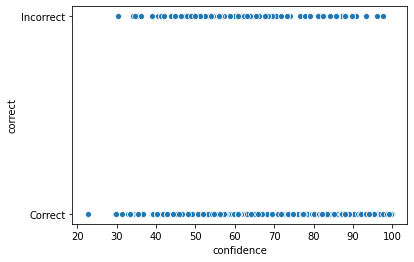

In [11]:
sns.scatterplot(x="confidence", y="correct", data=new)

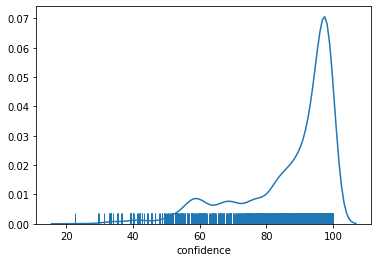

In [12]:
sns.distplot(new[new.correct == "Correct"].confidence, hist=False, rug=True);

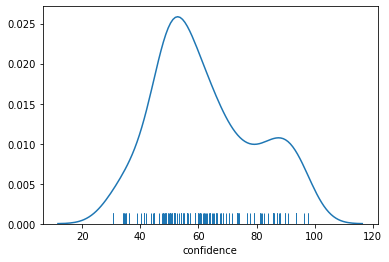

In [13]:
sns.distplot(new[new.correct == "Incorrect"].confidence, hist=False, rug=True);

In [14]:
new.groupby(["correct"]).Title.count()

correct
Correct      1463
Incorrect      66
Name: Title, dtype: int64

In [15]:
pd.DataFrame(new.groupby(["reviewed","correct"]).Title.count())

Title
reviewed    correct         
Array       Correct      599
            Incorrect     25
Bladder     Correct       26
Boards      Correct       12
            Incorrect      4
Doppler     Correct        4
            Incorrect      2
Fetal       Correct       29
            Incorrect      2
FullMachine Correct       27
            Incorrect      2
HH          Correct       50
MechProbe   Correct        6
            Incorrect     12
NDT         Correct       30
NotUS       Correct      545
            Incorrect     16
Phantom     Incorrect      1
PiezosNDT   Correct      113
            Incorrect      2
Wireless    Correct       22

In [16]:
#TODO = dfToTag
TODO = df
TODO["Hypothese"] = TODO["Title"].apply(lambda x: predict_from_text(str(x),False))
TODO[['new_group','confidence','new_category']] = pd.DataFrame(TODO.Hypothese.values.tolist(), index= TODO.index)
TODO

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/kelu/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-00d921cd23f2>", line 3, in <module>
    TODO["Hypothese"] = TODO["Title"].apply(lambda x: predict_from_text(str(x),False))
  File "/home/kelu/.local/lib/python3.6/site-packages/pandas/core/series.py", line 3848, in apply
    mapped = lib.map_infer(values, f, convert=convert_dtype)
  File "pandas/_libs/lib.pyx", line 2329, in pandas._libs.lib.map_infer
  File "<ipython-input-16-00d921cd23f2>", line 3, in <lambda>
    TODO["Hypothese"] = TODO["Title"].apply(lambda x: predict_from_text(str(x),False))
  File "<ipython-input-5-c6f9b651d315>", line 4, in predict_from_text
    prediction_svc = svc_model.predict(create_features_from_text(text))[0]
  File "<ipython-input-3-8b123ab30387>", line 31, in create_features_from_text
    df['Content_Clean'] = df['Content_Clean'].

KeyboardInterrupt: 

In [ ]:
DFxl = TODO[["value","_currencyID","ViewItemURLForNaturalSearch","Title","PrimaryCategoryID","Country","Description",'new_group','confidence','new_category']].reset_index()
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk("/home/kelu/ultrasound/ebaystrove/images/") for f in filenames if os.path.splitext(f)[1] == '.jpg']
imagesID = [x.split(".")[-2].split("/")[-1] for x in images]
LIMIT = len('/home/kelu/ultrasound/ebaystrove/images/233384138652.jpg')
L = len("/home/kelu/ultrasound/ebaystrove/images/")
DFxl["group"] = "None"
for k in images:
    if len(k) > (LIMIT + 1):
        ID = k.split("/")[-1].split(".")[-2]
        DFxl["group"].loc[DFxl.ItemID == ID] = k.split("/")[-2]
Final = DFxl[~(DFxl.group == "None")].reset_index().drop(['index'], axis=1) 
Final

In [ ]:
Final[["ItemID","ViewItemURLForNaturalSearch","Title","group","new_category"]].to_excel("verification.xlsx")


In [ ]:
images